#### Dependências necessárias e funções auxiliares

In [7]:
# dependências necessárias
import control as ct 
import matplotlib.pyplot as plt 
import numpy as np 
from IPython.display import Image

# funções auxiliares 
def print_graph(t, y, title, xlabel, ylabel, fig_number=1, source="Elaborada pelo autor"):
    plt.figure(figsize=(8, 6))
    plt.plot(t, y, linewidth=2)
    plt.title(f"Figura {fig_number} - {title}", fontsize=12, fontweight='bold', pad=20)
    plt.xlabel(xlabel, fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    plt.grid(True, alpha=0.3)
    fig = plt.gcf()
    fig.text(0.5, 0.01, f"Fonte: {source}", fontsize=9, style='italic', ha='center')
    plt.tight_layout(rect=[0, 0.03, 1, 1])
    plt.show()

# Trabalho computacional 

Esse trabalho computacional tem o objetivo de modelar e projetar o controle de um motor de corrente contínua (CC) utilizando espaços de estados.

## 1. Análise do sistema

### Modelagem física

A modelagem física do motor conduz ao seguinte sistema de equações

$$
\begin{cases}
V_t(t) = L_a \frac{d i_a(t)}{dt} + R_a i_a(t) + E_a(t) \\
E_a(t) = K_e \omega(t) \\
\omega(t) = \frac{d \theta(t)}{dt} \\
\tau_{ele}(t) - \tau_L(t) = J \frac{d \omega(t)}{dt} + b \omega(t) \\
\tau_{ele} = K_{\tau} i_a(t) \\
\tau_L(t) = J_L \frac{d \omega(t)}{dt} + b_L \omega(t)
\end{cases}
$$



| Variável | Descrição |
| :--- | :--- |
| $V_t(t)$ | tensão terminal (V) |
| $E_a(t)$ | força contra-eletromotriz (V) |
| $i_a(t)$ | corrente de armadura (A) |
| $\tau_{ele}(t)$ | torque da máquina (N.m) |
| $\tau_L(t)$ | torque de carga (N.m) |
| $\omega(t)$ | velocidade do eixo (rad/s) |
| $\theta(t)$ | posição do eixo (rad) |

### Parâmetros do motor
Os parâmetros do motor são apresentados na tabela a seguir:

| Variável | Descrição | Valor |
| :--- | :--- | :--- |
| $L_a$ | indut. armadura | 1,3 H |
| $R_a$ | resist. armadura | 0,3 $\Omega$ |
| $J$ | mom. inércia MCC | 0,0013 $kg.m^2$ |
| $b$ | amort. rotacional MCC | 0,00169 $N.m.s/rad$ |
| $J_L$ | mom. inércia de carga | 0,036056 $kg.m^2$ |
| $K_e$ | constante construtiva | 0,0055678 $'.s/rad$ |
| $K_{\tau}$ | constante construtiva | 0,23077 $N.m/A$ |
| $b_L$ | amort. rotacional carga | 0,0169 $N.m.s/rad$ |

In [8]:

la = 1.3 # indutância de armadura (H)
ra = 2.0 # resistência de armadura (ohms)
j = 0.0013 # momento de inércia (kg.m^2)
b = 0.00169 # amortecimento MCC (N.m.s/rad)
jl = 0.036056 # momento de inércia da carga (kg.m^2)
ke = 0.0055678 # constante construtiva (N.m/A)
kt = 0.23077 # constante construtiva (N.m/A)
bl = 0.0169 # amortecimento rotacional da carga (N.m.s/rad) 

### Diagrama de blocos do sistema

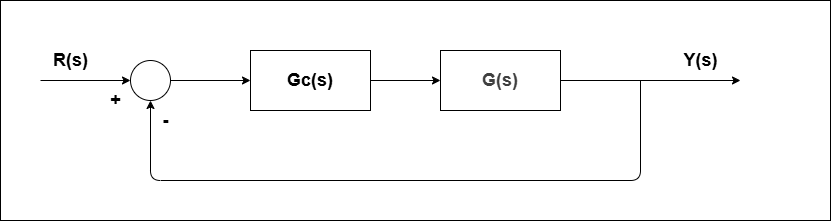

In [9]:
Image(filename='figs/diagrama_de_blocos.drawio.png')

### Resposta ao degrau unitário

#### a) Função da transferência da tensão do estator para velocidade

A partir das equações usadas para descrever o motor e considerando condições iniciais nulas é possível obter a seguinte função de transferência:

$$
G(s) = \frac{\Omega(s)}{V_i(s)} = \frac{K_t}{s^2[L_a(J + J_L)] + s[L_a(b + b_L) + R_a(J + J_L)] + [R_a(b + b_L) + K_eK_t]}
$$

In [10]:
coef_num_1 = [kt]
coef_denom_1 = [la*(j + jl), la*(b + bl) + ra*(j + jl), ra*(b + bl) + ke*kt]

print("Coeficientes do numerador: ", coef_num_1)
print("Coeficientes do denominador: ", coef_denom_1)

Coeficientes do numerador:  [0.23077]
Coeficientes do denominador:  [0.0485628, 0.098879, 0.038464881206]


Por fim, a resposta ao degrau unitária desse sistema é apresentada na figura 1

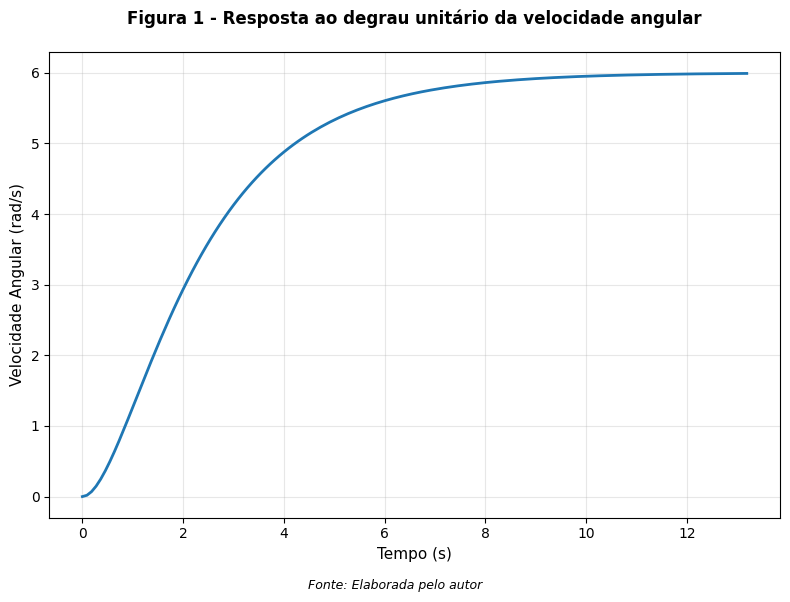

In [11]:
G_1 = ct.tf(coef_num_1, coef_denom_1)
# print("Função de transferência G(s):")
# print(G)
t, y =  ct.step_response(G_1)
print_graph(t, y, "Resposta ao degrau unitário da velocidade angular", "Tempo (s)", "Velocidade Angular (rad/s)")

#### b) Função do torque de carga para velocidade

A partir das equações usadas para descrever o motor e considerando condições iniciais nulas é possível obter a seguinte função de transferência:

$$
G(s) = \frac{\Omega(s)}{\tau_i(s)} = \frac{1}{s J_a + bl}
$$

In [12]:
coef_num_2 = [1]
coef_denom_2 = [jl, bl]

print("Coeficientes do numerador: ", coef_num_2)
print("Coeficientes do denominador: ", coef_denom_2)

Coeficientes do numerador:  [1]
Coeficientes do denominador:  [0.036056, 0.0169]


Por fim, a resposta ao degrau unitária desse sistema é apresentada na figura 2

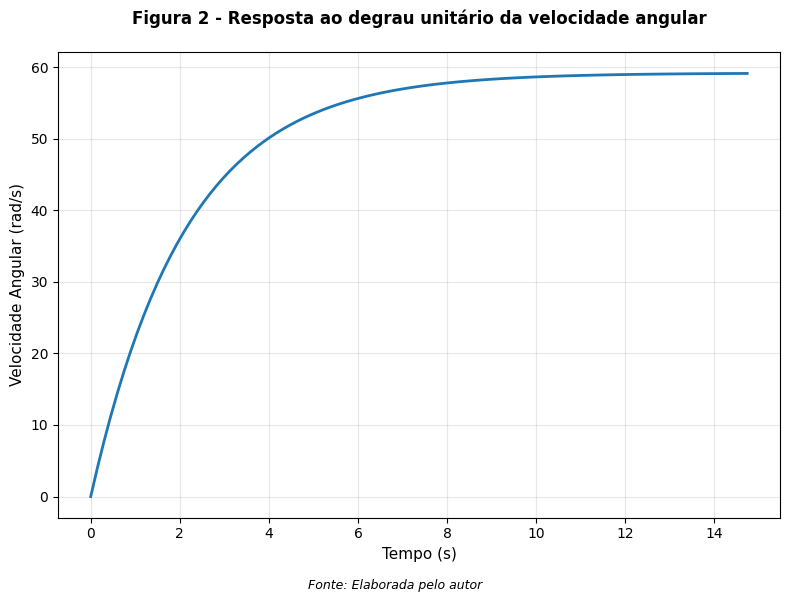

In [14]:
G_2 = ct.tf(coef_num_2, coef_denom_2)
# print("Função de transferência G(s):")
# print(G)
t, y = ct.step_response(G_2)
print_graph(t, y, "Resposta ao degrau unitário da velocidade angular", "Tempo (s)", "Velocidade Angular (rad/s)", 2)

## 2. Representação em espaços de estados

A análise das equações do motor revela que a corrente de armadura $i_a(t)$ e a velocidade angular $\omega(t)$ são relacionadas, mas não interdependentes. Como sua evolução temporal descreve adequadamente o comportamento do sistema, elas são escolhidas como as variáveis de estado.

O sistema possui como entradas a tensão terminal e o torque de carga e como saída a velocidade angular. Dessa forma, escrevendo as equações do motor CC em função das entradas e saídas obtêm-se
